/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [04:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC-ROC: 0.6242570512589605
AUC-PR: 0.23414650416353364
F1 Score: 0.240620957309185
Top 10 SHAP features: ['dti', 'dti_squared', 'credit.policy', 'int.rate', 'fico', 'installment', 'log.annual.inc', 'days.with.cr.line', 'purpose_enc', 'revol.bal']


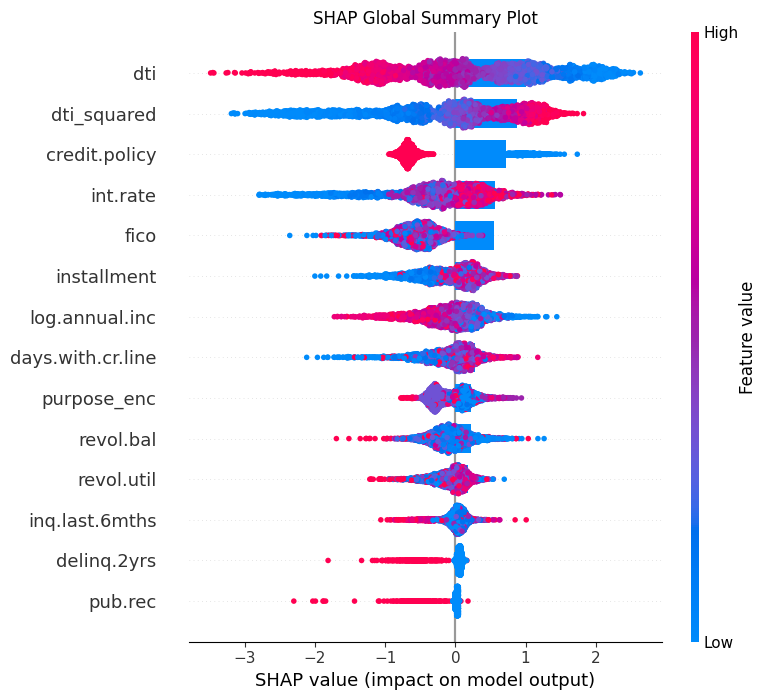

<Figure size 640x480 with 0 Axes>

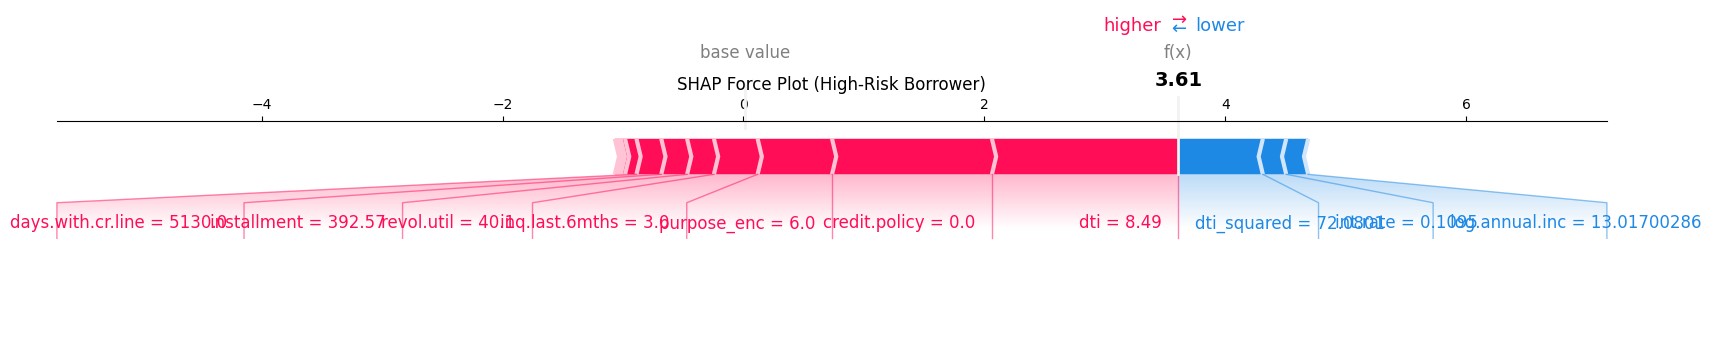

<Figure size 640x480 with 0 Axes>

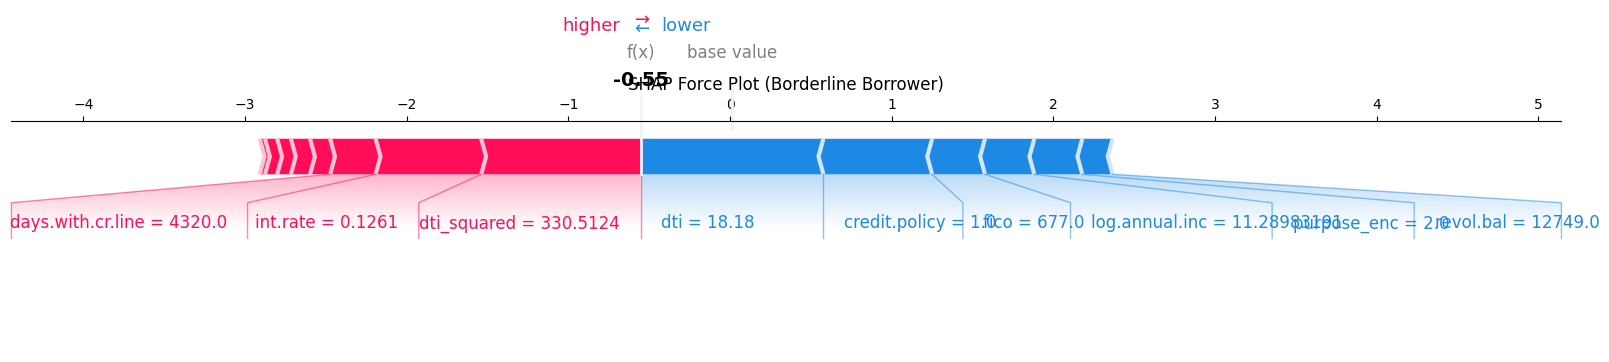

<Figure size 640x480 with 0 Axes>

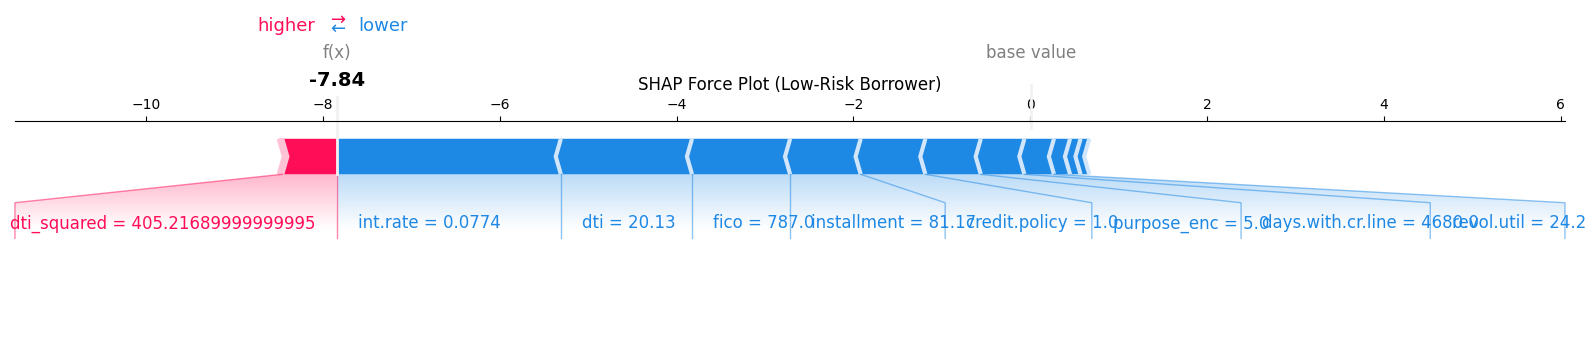

<Figure size 640x480 with 0 Axes>

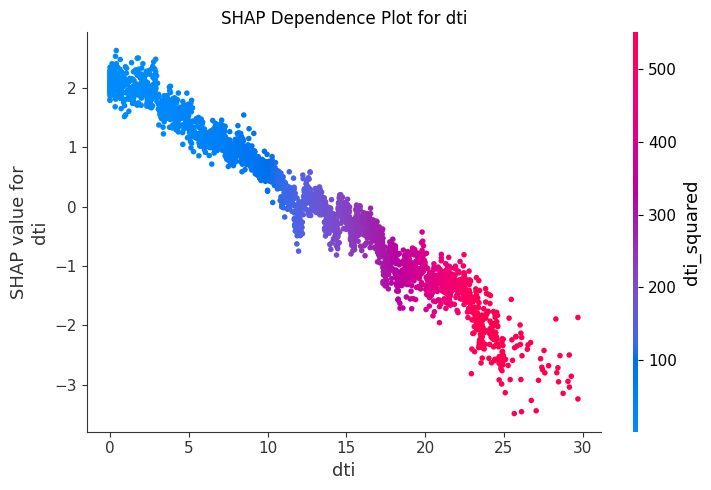

In [4]:
# INTERPRETABLE CREDIT RISK MODEL WITH SHAP EXPLANATION

# 1. Data Loading & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report, precision_recall_curve
import shap

# Load data
df = pd.read_csv('/content/loan_data.csv')

# 2. Data Cleaning & Feature Engineering
df = df.drop_duplicates()
df = df.dropna(subset=['not.fully.paid'])  # Drop rows with missing target

# Fill/encode missing categorical data (if any) and encode 'purpose'
df['purpose'] = df['purpose'].fillna('Unknown')
le = LabelEncoder()
df['purpose_enc'] = le.fit_transform(df['purpose'])

# Feature: Debt-income ratio squared (captures non-linear effect)
df['dti_squared'] = df['dti'] ** 2

# Features/labels
features = ['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
            'days.with.cr.line', 'revol.bal', 'revol.util', 'inq.last.6mths',
            'delinq.2yrs', 'pub.rec', 'purpose_enc', 'dti_squared']
X = df[features]
y = df['not.fully.paid']

# 3. Handling Imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42)

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# 4. Model Training & Tuning
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_res, y_res)

# 5. Predictions & Metrics
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_proba)
auc_pr = average_precision_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print('AUC-ROC:', auc_roc)
print('AUC-PR:', auc_pr)
print('F1 Score:', f1)

# 6. SHAP Analysis
explainer = shap.TreeExplainer(model)
# The shap_values array is ordered by the rows in X_test.
# X_test here should only contain features, not the 'score' column if added previously.
shap_values = explainer.shap_values(X_test)

# 6a. Global Feature Importance
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Top 10)")
plt.tight_layout()
plt.savefig("shap_summary_bar.png")

shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Global Summary Plot")
plt.tight_layout()
plt.savefig("shap_summary_all.png")

# Top 10 features
mean_shap = np.abs(shap_values).mean(axis=0)
top_indices = np.argsort(mean_shap)[::-1][:10]
top_features = [features[i] for i in top_indices]
print("Top 10 SHAP features:", top_features)

# 6b. Local SHAP Interpretation
# Select 3 profiles based on predicted probabilities
# Create a temporary DataFrame to hold scores for selection, without modifying the original X_test
X_test_with_scores = X_test.copy()
X_test_with_scores['score'] = y_proba

# Get the original DataFrame indices (labels) for the high, mid, and low-risk profiles
hi_original_label = X_test_with_scores.sort_values('score', ascending=False).iloc[0].name
low_original_label = X_test_with_scores.sort_values('score').iloc[0].name
mid_original_label = X_test_with_scores.iloc[(len(X_test_with_scores) // 2)].name

borrower_original_labels = [hi_original_label, mid_original_label, low_original_label]
profile_names = ['High-Risk', 'Borderline', 'Low-Risk']

for original_label, name in zip(borrower_original_labels, profile_names):
    plt.figure()
    # Get the positional index corresponding to the original_label within the current X_test DataFrame
    pos_idx = X_test.index.get_loc(original_label)

    # Use the positional index for shap_values (which is an array) and for X_test.iloc
    shap.force_plot(explainer.expected_value, shap_values[pos_idx], X_test.iloc[pos_idx], matplotlib=True, show=False)
    plt.title(f"SHAP Force Plot ({name} Borrower)")
    plt.savefig(f"shap_force_{name}.png", bbox_inches='tight')

# 7. SHAP dependence plot for the top feature
plt.figure()
# X_test should not contain the 'score' column here
shap.dependence_plot(top_features[0], shap_values, X_test, show=False)
plt.title(f"SHAP Dependence Plot for {top_features[0]}")
plt.tight_layout()
plt.savefig("shap_dependence.png")